In [1]:
import pandas as pd
import numpy as np
import nltk 
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

/Users/chenjiqing/anaconda3/envs/Class/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
import nltk
nltk.download('words')
nltk.download('stopwords')
words = nltk.corpus.words.words()
sw = stopwords.words('english')

[nltk_data] Downloading package words to
[nltk_data]     /Users/chenjiqing/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenjiqing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### load review data, clean the reviews, and save as .csv

In [3]:
df = pd.read_json('/Users/chenjiqing/Public/2020_Fall_term/data/Toys_and_Games_Reviews_training.json', lines=True)

In [4]:
df.shape

(1460818, 12)

In [10]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"08 12, 2012",BDF1A2B47461BE6FD7B8AD896005E061,5FC455C18F7DD81A071E51B6B60A72BD,73D759DCDF02B4DDBD3FB7D29E88C6C3,I always look for this brand of cards because ...,durable cards,1344729600,NaN,NaN,NaN
1,5,False,"01 24, 2011",91BDB36705C359620E8E0959DEFCFC79,5FC455C18F7DD81A071E51B6B60A72BD,80C0DC9C8FAB1C9BE0E1D5E83965360C,"Other than KEM's or DaVinchi brands, these car...",some of the best Cards,1295827200,4,NaN,NaN
2,5,True,"11 18, 2016",B14C8E6A493C844D2AEDCC61207BB6B1,5FC455C18F7DD81A071E51B6B60A72BD,C133754F62F0EB10D1FFF543786622DC,The better ive ever seen!!!! Excelent!,Five Stars,1479427200,NaN,NaN,NaN
3,5,True,"03 7, 2016",D53FA93ED4A6B67662D920473DE9C7F7,5FC455C18F7DD81A071E51B6B60A72BD,59820C0C923F245A167B53E24FFBF5BB,get it,Five Stars,1457308800,NaN,NaN,NaN
4,5,False,"05 22, 2015",B59D69D00FEA8B83388D292010CAB2E9,5FC455C18F7DD81A071E51B6B60A72BD,2843F6C4145178E4F87A6CD895F4887F,Really nice cards. Will make great use of them...,playing cards,1432252800,NaN,NaN,NaN


## Count review

In [4]:
# count review number
df_count = df.groupby(["asin"])['reviewText'].count().reset_index(name="count")
df_count.head()

,asin,count
0,000254CDA01E5AE839E7EE3F6FC1D2F1,24
1,0002E81AED1B9840434EE28E39876BE4,13
2,0003806D9BE7957D8AB9AF9EC04F52D0,6
3,00049B538C925B3EF702FFF6FBD48DFE,8
4,0004D0377FDC88F2DD349170E36324E7,5


## Histogram

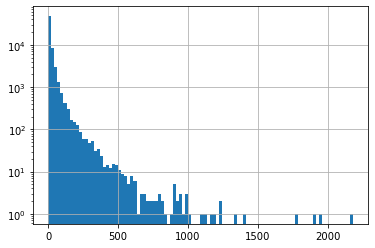

In [14]:
import matplotlib.pyplot as plt
hist = df_count.hist(bins = 100)
plt.yscale('log')
plt.title('')
#plt.xlabel('review count')
#plt.ylabel('log(# of products)')
plt.savefig('review count.png')

In [12]:
print("Number of samples: {} Number of Features: {}".format(df.shape[0], df.shape[1]))

Number of samples: 1460818 Number of Features: 12


In [13]:
clean_df = df[df['reviewText'].notna()]
df2 = clean_df[['asin', 'overall', 'reviewText', 'summary']]

In [14]:
avg = df2[['asin', 'overall']].groupby('asin').mean()
# assian traget=1 if averaged overall>4.5 and target=0 otherwise
avg2 = avg.assign(
    Target = lambda dataframe: dataframe['overall'].map(lambda overall: "1" if overall >4.5 else "0") 
)
avg2 = avg2.rename_axis("asin").reset_index()
avg2.columns = ['asin','overall_avg', 'Target']

# select coloumns
df3 = df2[['asin', 'overall', 'reviewText', 'summary']]

df4 = df3.groupby('asin')['reviewText'].apply(' '.join).reset_index()
df4.head()
#df4.shape

,asin,reviewText
0,000254CDA01E5AE839E7EE3F6FC1D2F1,The child who recieved them opened the box and...
1,0002E81AED1B9840434EE28E39876BE4,Great gift for my special needs cousin Blocks ...
2,0003806D9BE7957D8AB9AF9EC04F52D0,I needed something to occupy kids indoors that...
3,00049B538C925B3EF702FFF6FBD48DFE,This is a very nicely detailed and painted die...
4,0004D0377FDC88F2DD349170E36324E7,Cute This bear is so cool and cute. The fabric...


In [27]:
Senti = pd.read_csv('dft_TextBlobSentAdded.csv')
avgSenti = Senti[['asin', 'sentiment_scores']].groupby('asin').mean()
avgSenti.head()
avgSenti.shape

(63017, 1)

In [20]:
# add target and count to df4
dft = df4.merge(avg2, on = 'asin', how ='left')
dft = dft.merge(df_count, on = 'asin', how ='left')
dft = dft.merge(avgSenti, on = 'asin', how ='left')
dft.head()
dft.shape
#dft.to_csv('df_combined_text.csv')

In [3]:
dft = pd.read_csv('df_combined_text.csv')
dft

,Unnamed: 0,Unnamed: 0.1,asin,reviewText,overall_avg,Target,count,sentiment_scores
0,0,0,000254CDA01E5AE839E7EE3F6FC1D2F1,The child who recieved them opened the box and...,4.625000,1,24,0.487121
1,1,1,0002E81AED1B9840434EE28E39876BE4,Great gift for my special needs cousin Blocks ...,2.538462,0,13,-0.223308
2,2,2,0003806D9BE7957D8AB9AF9EC04F52D0,I needed something to occupy kids indoors that...,5.000000,1,6,0.464500
3,3,3,00049B538C925B3EF702FFF6FBD48DFE,This is a very nicely detailed and painted die...,4.625000,1,8,0.133913
4,4,4,0004D0377FDC88F2DD349170E36324E7,Cute This bear is so cool and cute. The fabric...,5.000000,1,5,0.557400
...,...,...,...,...,...,...,...,...
63012,63012,63012,FFFAB16CD5964F60F014EFAA1210AFEE,These stickers are really adorable. The variet...,4.928571,1,14,0.517586
63013,63013,63013,FFFAB94C16EAEC9E1DEBF24E231C53BB,"great little toy. <div id=""video-block-R3SMI4X...",4.380952,0,21,0.530857
63014,63014,63014,FFFB0C64CBC232115CE8FFF2BE870122,I am a collector of everything Firefly / Seren...,4.850000,1,20,0.529530
63015,63015,63015,FFFB5BB91B42C9A34457AD075B499DF9,"This made a cute Easter gift, but was soon for...",4.090909,0,11,0.557400


In [4]:
dft_small = dft.sample(n =100)
print(dft_small.Target.value_counts())
dft_small['count']

1    52
0    48
Name: Target, dtype: int64


1410     63
4004      6
7125     12
7287      5
3296      5
         ..
2957     38
53156     7
51351     7
12211     7
20225    23
Name: count, Length: 100, dtype: int64

# Bag of Words

In [20]:
# create a count vectorizer object
token = RegexpTokenizer(r'[a-zA-Z]+')
count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)

# fit the count vectorizer using the text data
text_counts = count_vectorizer.fit_transform(dft['reviewText'])

# collect the vocabulary items used in the vectorizer
# dictionary = count_vectorizer.vocabulary_.items()

# words appear in documents.
tokens = count_vectorizer.get_feature_names()
#print(tokens)

In [22]:
# split traning data and testing data
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, dft['Target'], test_size=0.2, random_state=1)

### Bag of Words-multinomial NB

In [23]:
# from sklearn.model_selection import cross_val_score ## for cross-validation
from sklearn import metrics

clf = MultinomialNB().fit(X_train, y_train)

predicted= clf.predict(X_test)

print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
from sklearn.metrics import classification_report
print(classification_report(y_test,predicted))

# scores = cross_val_score(clf, text_counts, dft['Target'], cv=5) ## for cross-validation
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) ## for cross-validation

MultinomialNB Accuracy: 0.7145350682323072
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      5774
           1       0.71      0.80      0.75      6830

   micro avg       0.71      0.71      0.71     12604
   macro avg       0.72      0.71      0.71     12604
weighted avg       0.72      0.71      0.71     12604



### Bag of Words- logisticRegression

In [24]:
#Import model
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn import metrics
#Create a Classifier
clf2 = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel

#Train the model using the training sets
clf2.fit(X_train, y_train)

#Predict the response for test dataset
y_pred2 = clf2.predict(X_test)
# print(y_pred)
print("LASSO-LR Accuracy:",metrics.accuracy_score(y_test, y_pred2))
# print(clf.decision_function(X_test))
# print(clf.predict_proba(X_test))

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred2))

LASSO-LR Accuracy: 0.7711044112980007
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      5774
           1       0.78      0.81      0.79      6830

   micro avg       0.77      0.77      0.77     12604
   macro avg       0.77      0.77      0.77     12604
weighted avg       0.77      0.77      0.77     12604



### Bag of Words- logisticRegression-CrossValidation

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics

#Create a svm Classifier
clf3 = LogisticRegressionCV(penalty='l1', solver='liblinear',cv=10) # Linear Kernel

#Train the model using the training sets
clf3.fit(X_train, y_train)
#Predict the response for test dataset
y_pred3 = clf3.predict(X_test)
# print(y_pred2)
print("logisticRegression-cross-validation Accuracy:",metrics.accuracy_score(y_test, y_pred3))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred3))

# TFIDF

In [4]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(dft['reviewText'])

In [6]:
# add count into text_tf (sparse matrix)
from scipy import sparse
text_tf_count = sparse.hstack((text_tf,np.array(dft['count'])[:,None]))
text_tf_senti = sparse.hstack((text_tf,np.array(dft['sentiment_scores'])[:,None]))
text_tf_count_senti = sparse.hstack((text_tf_count,np.array(dft['sentiment_scores'])[:,None]))
print(text_tf_count_senti)

  (0, 59838)	0.03202725550420936
  (0, 34013)	0.020935217148514658
  (0, 125011)	0.050770217024558355
  (0, 84462)	0.02079476564084484
  (0, 71347)	0.0972614489184268
  (0, 12031)	0.0337512187348777
  (0, 94733)	0.04365437244001424
  (0, 57076)	0.03191264206170739
  (0, 127485)	0.07537186735762977
  (0, 97615)	0.04979221748757807
  (0, 27081)	0.05606635236335404
  (0, 34145)	0.04794696264067572
  (0, 79468)	0.019839643657088634
  (0, 65100)	0.02593333074705919
  (0, 98621)	0.05934564609848282
  (0, 74035)	0.022214204178012842
  (0, 104710)	0.05133020829860741
  (0, 98607)	0.040402145551324445
  (0, 18698)	0.06083717496056019
  (0, 134304)	0.04301043126314798
  (0, 139348)	0.0655237114760431
  (0, 69612)	0.029335807392840075
  (0, 70962)	0.02781983130321231
  (0, 69869)	0.022391595773542758
  (0, 97601)	0.0666507672379206
  :	:
  (62992, 152987)	0.4830799999999999
  (62993, 152987)	0.4406708333333333
  (62994, 152987)	0.5574
  (62995, 152987)	0.2520454545454545
  (62996, 152987)	0.55740

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(text_tf, dft_small['Target'], test_size=0.2, random_state=2)
X_train = text_tf_senti
y_train = dft['Target']

## SMOTE

In [6]:
# pip install imblearn
# check version number
import imblearn
print(imblearn.__version__)
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__)) # The scikit-learn version should be 0.23.2.

0.7.0
The scikit-learn version is 0.23.2.


### TFIDF-multinomial NB

In [20]:
clf = MultinomialNB().fit(X_train, y_train)

predicted= clf.predict(X_test)


print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test,predicted))

MultinomialNB Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



## TFIDF-BernoulliNB

In [40]:
from sklearn.naive_bayes import BernoulliNB
clf_BNB = BernoulliNB().fit(X_train, y_train)

predicted_BNB= clf_BNB.predict(X_test)

print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted_BNB))
print(classification_report(y_test,predicted_BNB))

MultinomialNB Accuracy: 0.6090923516344018
              precision    recall  f1-score   support

           0       0.60      0.43      0.50      5774
           1       0.61      0.76      0.68      6830

    accuracy                           0.61     12604
   macro avg       0.61      0.60      0.59     12604
weighted avg       0.61      0.61      0.60     12604



## TFIDF-CategoricalNB

In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf_CateNB = CategoricalNB().fit(X_train.toarray(), y_train)

predicted_CateNB= clf_CateNB.predict(X_test.toarray())

print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted_CateNB))
print(classification_report(y_test,predicted_CateNB))

### TFIDF-GaussianProcessClassifier

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)

gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train.toarray(), y_train)
y_pred_gpc = gpc.predict(X_test.toarray())
# print(y_pred2)
print("GaussianProcessClassifier-Accuracy:",metrics.accuracy_score(y_test, y_pred_gpc))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_gpc))

## TFIDF - logistic regression

In [6]:
#Import model
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn import metrics
import time
from sklearn.model_selection import cross_val_score

#Create a Classifier
clf3 = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel


#Train the model using the training sets
#clf3.fit(X_train, y_train)
#Predict the response for test dataset
#y_pred3 = clf3.predict(X_test)
# print(y_pred3)
#print("logisticRegression-Accuracy:",metrics.accuracy_score(y_test, y_pred3))
#from sklearn.metrics import classification_report
#print(classification_report(y_test,y_pred3))
#start_time = time.time()
scores = cross_val_score(clf3, X_train, y_train, cv=10, scoring='precision')
scores2 = cross_val_score(clf3, X_train, y_train, cv=10, scoring='recall')
scores3 = cross_val_score(clf3, X_train, y_train, cv=10, scoring='f1')
#print("--- %s seconds ---" % (time.time() - start_time))
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

Precision: 0.82 (+/- 0.01)
Recall: 0.85 (+/- 0.01)
F1-score: 0.83 (+/- 0.01)


### TFIDF+Senti - logistic regression

In [13]:
#Import model
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

X_train = text_tf_senti
y_train = dft['Target']

#Create a Classifier
clf_TFIDF_vader = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel
clf_TFIDF_vader.fit(X_train, y_train)
#Train the model using the whole data
#scores = cross_val_score(clf_TFIDF_vader, X_train, y_train, cv=10, scoring='precision')
#scores2 = cross_val_score(clf_TFIDF_vader, X_train, y_train, cv=10, scoring='recall')
#scores3 = cross_val_score(clf_TFIDF_vader, X_train, y_train, cv=10, scoring='f1')
#print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
#print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

LogisticRegression(C=1, penalty='l1', solver='liblinear')

## TFIDF-SMOTE-logistic regression (CV = 10)

In [7]:
#Import model
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn import metrics
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

model = LogisticRegression(C=1, penalty='l1', solver='liblinear') # Linear Kernel
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

scores = cross_val_score(model, X, y, cv=10, scoring='precision')
scores2 = cross_val_score(model, X, y, cv=10, scoring='recall')
scores3 = cross_val_score(model, X, y, cv=10, scoring='f1')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

Precision: 0.82 (+/- 0.06)
Recall: 0.83 (+/- 0.01)
F1-score: 0.82 (+/- 0.03)


## TFIDF-SVM

In [12]:
clf4 = SVC(kernel = 'linear')
start_time = time.time()
scores = cross_val_score(clf4, X_train, y_train, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
#scores
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

--- 11.964690923690796 seconds ---
F1-score: 0.78 (+/- 0.09)


## TFIDF-Decision Tree

In [13]:
clf5 = DecisionTreeClassifier()
start_time = time.time()
scores = cross_val_score(clf5, X_train, y_train, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
#scores
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

--- 3.51294207572937 seconds ---
F1-score: 0.64 (+/- 0.11)


## TFIDF-VotingClassifier (only use 10,000 samples; memmory isn't enough for all samples)

In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

clf1 = LogisticRegression(C=1, penalty='l1', solver='liblinear')
clf2 = MultinomialNB() # other
clf3 = RandomForestClassifier(n_estimators=50, random_state=1)
clf4 = SVC(kernel = 'linear')
clf5 = DecisionTreeClassifier()
eclf = VotingClassifier(estimators=[('lr', clf1),('svc',clf4),('rf', clf3), ('gnb', clf2),('dt',clf5)],voting='hard')

#start_time = time.time()
scores = cross_val_score(eclf, X_train.toarray(), y_train, cv=10, scoring='precision')
scores2 = cross_val_score(eclf, X_train.toarray(), y_train, cv=10, scoring='recall')
scores3 = cross_val_score(eclf, X_train.toarray(), y_train, cv=10, scoring='f1')
#print("--- %s seconds ---" % (time.time() - start_time))
#scores
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))
#eclf.fit(X_train.toarray(), y_train)
#y_pred_V = eclf.predict(X_test.toarray())
#print('Late Fusion- LR,GNB,RF')
#print(classification_report(y_test,y_pred_V))

--- 178.06399607658386 seconds ---
F1-score: 0.76 (+/- 0.09)


## TFIDF-Late Fusion

In [43]:
# late fusion

clflg = LogisticRegression(C=1, penalty='l1', solver='liblinear')
clfnb = MultinomialNB()
clfrf = RandomForestClassifier(n_estimators=50, random_state=1)
clfdt = DecisionTreeClassifier(random_state=0)

# fit training data
clflg.fit(X_train, y_train)
clfnb.fit(X_train, y_train)
clfrf.fit(X_train, y_train)
clfdt.fit(X_train, y_train)

alphas = np.linspace(0, 1, 5)
#print(alphas)
clfs = [clflg, clfnb, clfrf, clfdt]

# probability threshold
pt = 0.5

for alpha1 in alphas:
    for alpha2 in alphas:
        if(alpha1 + alpha2>1):
            continue
        for alpha3 in alphas:
            if(alpha1 + alpha2 + alpha3 > 1):
                continue
            prob = (alpha1*clfs[0].predict_proba(X_test) + \
                    alpha2*clfs[1].predict_proba(X_test) + \
                    alpha3*clfs[2].predict_proba(X_test) + \
                    (1 - alpha1 - alpha2 - alpha3)*clfs[3].predict_proba(X_test))[:, 1]
            #print(prob)
            y_pred = np.zeros(len(prob))
            idx = (prob>=pt)
            y_pred[idx] = 1
            print('alpha1 = ', alpha1, 'alpha2 = ', alpha2, 'alpha3 = ', alpha3)
            print(classification_report(y_test,y_pred))

alpha1 =  0.0 alpha2 =  0.0 alpha3 =  0.0
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      5774
           1       0.68      0.69      0.69      6830

    accuracy                           0.66     12604
   macro avg       0.66      0.66      0.66     12604
weighted avg       0.66      0.66      0.66     12604

alpha1 =  0.0 alpha2 =  0.0 alpha3 =  0.25
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      5774
           1       0.68      0.69      0.69      6830

    accuracy                           0.66     12604
   macro avg       0.66      0.66      0.66     12604
weighted avg       0.66      0.66      0.66     12604

alpha1 =  0.0 alpha2 =  0.0 alpha3 =  0.5
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      5774
           1       0.68      0.69      0.69      6830

    accuracy                           0.66     12604
 

In [13]:
y_pred_V

array([0, 1, 1, ..., 0, 0, 0])

## TFIDF-LogisticRegression GridSearchCV

In [12]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
#from imblearn.over_sampling import SMOTE
#oversample = SMOTE()
#X, y = oversample.fit_resample(X_train, y_train)
clf3 = LogisticRegression(penalty='l1', solver='liblinear')
params = {'C': [1.0, 100.0]}
grid = GridSearchCV(estimator=clf3, param_grid=params, cv=10, scoring = 'f1')
grid.fit(X_train, y_train)
y_pred_V = grid.predict(X_test)
print(classification_report(y_test,y_pred_V))
print(grid.cv_results_)
print("Best parameters from gridsearch: {}".format(grid.best_params_))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.40      1.00      0.57         8

    accuracy                           0.40        20
   macro avg       0.20      0.50      0.29        20
weighted avg       0.16      0.40      0.23        20

{'mean_fit_time': array([0.0029882 , 0.01823843]), 'std_fit_time': array([0.00099729, 0.01105432]), 'mean_score_time': array([0.00181797, 0.00306613]), 'std_score_time': array([0.00099287, 0.00285274]), 'param_C': masked_array(data=[1.0, 100.0],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1.0}, {'C': 100.0}], 'split0_test_score': array([0.66666667, 0.5       ]), 'split1_test_score': array([0.66666667, 0.85714286]), 'split2_test_score': array([0.66666667, 0.57142857]), 'split3_test_score': array([0.66666667, 0.8       ]), 'split4_test_score': array([0.66666667, 0.5       ]), 'split5_test_score': array([0.66666

/Users/chenjiqing/anaconda3/envs/Class/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Prediction csv (not includes SMOTE / Late Fusion / GridSearch / cross-validation)

In [8]:
toy_test = pd.read_json('/Users/chenjiqing/Public/2020_Fall_term/data/Toys_and_Games_Reviews_test.json', lines=True)

In [9]:
toy_test.head()

,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,True,"01 9, 2014",F65C6B80659643241B55D2F8606CA762,B53842B7FB95A7EED604789C4527FED4,C13E13DA2073260C2194C15D782E86A9,I bought this item for my granddaughter and sh...,xmas present,1389225600,NaN,NaN,NaN
1,True,"01 7, 2014",B59B4F985BFB64754C6DA13A1825344C,B53842B7FB95A7EED604789C4527FED4,EB6C1EA748A0926CF57E2915043A1B2C,My kids didn't care for this. It's not exactly...,"Not what I expected, my kids didn't care for it.",1389052800,NaN,NaN,NaN
2,True,"06 17, 2014",7CA53EA426A3925851477B594C14C1B1,B53842B7FB95A7EED604789C4527FED4,3C05450791D51827DF4ADAC95DB284C3,"Don't waste time or money on this, it does not...",Does not work,1402963200,NaN,NaN,NaN
3,True,"03 26, 2014",2421E7DA831836AC70B3599A07CC6813,B53842B7FB95A7EED604789C4527FED4,EFB1465497243F7027F6D6C101F3CDDC,This is a fun idea but unfortunately the handl...,Fun idea,1395792000,NaN,NaN,NaN
4,False,"02 22, 2014",3A27A6CCDFEB41598C949DEE4B130773,B53842B7FB95A7EED604789C4527FED4,3CF804E7182AB12879C33C914E1C5CD8,This is a very sturdy tub toy and has handled ...,Super toy and very durable.,1393027200,NaN,NaN,NaN


In [14]:
vader_sntimentscore_test = pd.read_csv('dft_test_vaderSentimentAdded.csv')
avg_vader_sntimentscore_test = vader_sntimentscore_test[['asin', 'sentiment_scores']].groupby('asin').mean()
avg_vader_sntimentscore_test

/Users/chenjiqing/anaconda3/envs/Class/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sentiment_scores
asin,
00027761289A98A2884B5F152D3DBF91,0.382740
000D550D33ABEA8BAF3C8E0FD88C1707,0.579656
0024011FC5EBE2E578E9032EC2EEE3EA,0.527580
00255AA8E14A573176D24AC68524541E,0.678940
00290349FBB97F31976D0471975A4789,0.570060
...,...
FFE0E00A3198C981F461CA920E1BE2E0,0.863050
FFE23C8B29D211456D9774F49E277905,0.439300
FFF41906931B0E2371E123299500D8E5,0.364782


In [11]:
# select coloumns
toy_test2 = toy_test[['asin', 'reviewText']]
clean_toy_test = toy_test2[toy_test2['reviewText'].notna()]
print(clean_toy_test.shape)
clean_toy_test2 = clean_toy_test.groupby('asin')['reviewText'].apply(' '.join).reset_index()
clean_toy_test2.head()
print(clean_toy_test2.shape)
print(clean_toy_test2.head())

(367913, 2)
(15755, 2)
                               asin  \
0  00027761289A98A2884B5F152D3DBF91   
1  000D550D33ABEA8BAF3C8E0FD88C1707   
2  0024011FC5EBE2E578E9032EC2EEE3EA   
3  00255AA8E14A573176D24AC68524541E   
4  00290349FBB97F31976D0471975A4789   

                                          reviewText  
0  Bought for a contest. Although for a child it ...  
1  I do a lot of model kit building, mainly warsh...  
2  I bought this game for the kids at my son's 2n...  
3  I bought this as a gift and the recipient abso...  
4  Daughter likes this very much. Cheap alternati...  


In [15]:
tf2=TfidfVectorizer(vocabulary = tf.vocabulary_)
text_tf2= tf2.fit_transform(clean_toy_test2['reviewText'])
text_tf_senti_test = sparse.hstack((text_tf2,np.array(avg_vader_sntimentscore_test['sentiment_scores'])[:,None]))
print(text_tf_senti_test)

  (0, 151962)	0.023741331568156925
  (0, 150233)	0.04345880328538978
  (0, 149852)	0.09747095777753212
  (0, 149579)	0.06048949819576235
  (0, 149535)	0.06183491648218076
  (0, 149032)	0.2778927754827474
  (0, 149007)	0.4872246723760914
  (0, 148765)	0.051447773837739984
  (0, 148460)	0.027844353062162683
  (0, 148136)	0.06312839290438638
  (0, 148060)	0.025540837543542732
  (0, 147699)	0.02744615601266229
  (0, 147326)	0.04353980785843322
  (0, 144443)	0.03814688138154437
  (0, 144436)	0.06730124544369397
  (0, 143947)	0.05292031195780934
  (0, 138762)	0.044955461570473816
  (0, 138179)	0.05761758813169907
  (0, 136830)	0.01981248823203037
  (0, 136132)	0.2620215065391931
  (0, 134375)	0.06675042782912839
  (0, 133683)	0.15166240771362147
  (0, 130133)	0.07600260619822456
  (0, 128897)	0.09791091504848393
  (0, 126167)	0.03350106024236067
  :	:
  (15730, 152986)	0.7702571428571429
  (15731, 152986)	0.4531125
  (15732, 152986)	0.5680615384615384
  (15733, 152986)	0.6554560137457043
  (

In [16]:
y_toy_test_pred = clf_TFIDF_vader.predict(text_tf_senti_test)

In [17]:
print(y_toy_test_pred)

[0 1 0 ... 0 1 0]


In [18]:
dft_predict1 = clean_toy_test2[['asin']]
print(dft_predict1)
dft_predict1['preds'] = y_toy_test_pred
print(dft_predict1)
dft_predict1.to_csv('predictions.csv', index=False)

                                   asin
0      00027761289A98A2884B5F152D3DBF91
1      000D550D33ABEA8BAF3C8E0FD88C1707
2      0024011FC5EBE2E578E9032EC2EEE3EA
3      00255AA8E14A573176D24AC68524541E
4      00290349FBB97F31976D0471975A4789
...                                 ...
15750  FFE0E00A3198C981F461CA920E1BE2E0
15751  FFE23C8B29D211456D9774F49E277905
15752  FFF41906931B0E2371E123299500D8E5
15753  FFF574CC84FD43D875FF7257B3797BF3
15754  FFF970B0EBBEA7752C6BAEBE3F4361D8

[15755 rows x 1 columns]
                                   asin  preds
0      00027761289A98A2884B5F152D3DBF91      0
1      000D550D33ABEA8BAF3C8E0FD88C1707      1
2      0024011FC5EBE2E578E9032EC2EEE3EA      0
3      00255AA8E14A573176D24AC68524541E      1
4      00290349FBB97F31976D0471975A4789      1
...                                 ...    ...
15750  FFE0E00A3198C981F461CA920E1BE2E0      0
15751  FFE23C8B29D211456D9774F49E277905      1
15752  FFF41906931B0E2371E123299500D8E5      0
15753  FFF574CC84FD43D87